In [2]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(1):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)


from src import decode_moddeling, prefill_moddeling, get_best_parallization_strategy
from src.LLM_inference.utils import get_inference_system

import pandas as pd
from plotnine import *
import plotnine as p9
import numpy as np
from variables import *

/Users/abambhaniya3/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/Users/abambhaniya3/Work/DL_codes/chatGPT_inference/System paper charts


In [3]:
# This will reload the imported modules (e.g. get_decode_model_characterstics) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2   

### Variables

## Number of Nodes BW

In [4]:
System_names_in_plot

['TPUv5e',
 'H100',
 'MI300X',
 'Gaudi3',
 'Sys_QA',
 'Sys_Chat',
 'Sys_RAG_QA',
 'Sys_Summ',
 'Sys_Code']

In [5]:
system_list = [
               {'Flops': 800, 'Memory_size': 40, 'Memory_BW': 32000, 'ICN': 300 , 'real_values':True},
               {'Flops': 800, 'Memory_size': 40, 'Memory_BW': 24000, 'ICN': 300 , 'real_values':True},
               {'Flops': 800, 'Memory_size': 40, 'Memory_BW': 16000, 'ICN': 300 , 'real_values':True},
               {'Flops': 800, 'Memory_size': 40, 'Memory_BW':  8000, 'ICN': 300 , 'real_values':True},
               {'Flops': 800, 'Memory_size': 40, 'Memory_BW':  4000, 'ICN': 300 , 'real_values':True},]
System_names_in_plot = ['8x', '6x', '4x', '2x', '1x']

Model_list = [ 'mixtral_7x8',  'gpt-3']
Model_names_in_plot = ['Mixtral-8x7B', 'GPT3-175B'] ## Only to be used for plot

In [6]:
data = []
batch_size_list = [1]
bits = 'int8'
for usecase in Decode_requirements.keys():
    b,bb,in_tokens, out_tokens, _ = Decode_requirements[usecase]
    for model in Model_list:
        model_df, summary_table = decode_moddeling(model = model, batch_size = max(batch_size_list), Bb = bb ,
                                input_tokens = in_tokens, output_tokens = out_tokens, model_profilling=True,
                                tensor_parallel = 1, pipeline_parallel = 1, bits=bits)
        Total_memory_required = (summary_table.loc[0,'Model Weights (MB)'] + summary_table.loc[0,'KV Cache (MB)'])   ## MBs
        system_name = system_list[-1]
        system = get_inference_system(system_name = system_name, bits = bits)
        Node_memory_size = system.get_off_chip_mem_size()       ## In MBs
        Num_nodes = Total_memory_required / Node_memory_size
        if Num_nodes <= 1:
            Num_nodes = 1
        else:
            Num_nodes = int(np.power(2,np.ceil(np.log2(Num_nodes))))
        Memory_amount_required = Total_memory_required
        ##### RE verifying the memory sizes
        while 1:
            try:    ## Check if model fits
                Parallelism_row = get_best_parallization_strategy(stage='decode', model=model, total_nodes=Num_nodes, batch_size = max(batch_size_list), beam_size = bb,
                            input_tokens = in_tokens, output_tokens = out_tokens,
                            system_name = system_name, bits=bits, debug=False)
                break
            except: ## If model doesn't fit, have 2x number of cores.
                Num_nodes *= 2
        # print(model, system_name, Num_nodes, Parallelism_row)
        model_df, summary_table = decode_moddeling(model = model, batch_size = max(batch_size_list)/Parallelism_row['PP'].values[0], Bb = bb ,
                            input_tokens = in_tokens, output_tokens = out_tokens, model_profilling=True,
                            tensor_parallel = Parallelism_row['TP'].values[0], pipeline_parallel = Parallelism_row['PP'].values[0], bits=bits)
        Memory_amount_required = (summary_table.loc[0,'Model Weights (MB)'] + summary_table.loc[0,'KV Cache (MB)'])   ## MBs

            
        ### Verified the num nodes
        TP = Parallelism_row['TP'].values[0]
        PP = Parallelism_row['PP'].values[0] 
        Node_total_memory = TP * PP * Node_memory_size 
        for system_name in system_list:

            for b in batch_size_list:
                data.append([system_name, usecase, model, b, Total_memory_required, TP, PP, Node_total_memory]+list(summary_table.values[0]))
df = pd.DataFrame(data, columns=(['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP', 'PP', 'Cores Total Memory (MB)']+list(summary_table.columns)) )


/Users/abambhaniya3/Work/DL_codes/chatGPT_inference/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 43.25 GB, KV Cache:0.29296875 
/Users/abambhaniya3/Work/DL_codes/chatGPT_inference/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 162.0 GB, KV Cache:3.955078125 
/Users/abambhaniya3/Work/DL_codes/chatGPT_inference/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 43.25 GB, KV Cache:0.48828125 
/Users/abambhaniya3/Work/DL_codes/chatGPT_inference/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 162.0 GB, KV Cache:10.986328125 
/Users/abambhaniya3/Work/DL_codes/chatGPT_inference/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 43.

In [7]:
df[df['Model'] == 'gpt-4']

,System,Usecase,Model,Batch,Req Memory Size(MB),TP,PP,Cores Total Memory (MB),MACs (MFLOP),Total Data (MB),Model Weights (MB),Unused Weights (MB),KV Cache (MB),AR data (MB),Pipe data (MB)


In [8]:
df["Latency (ms)"] = ""
df["QPS (Query/s)"] = ""
df["Prefill Attn Time (ms)"] = ""
df["Prefill GEMM Time (ms)"] = ""
df["Prefill Communication Time (ms)"] = ""
df["Decode Attn Time (ms)"] = ""
df["Decode GEMM Time (ms)"] = ""
df["Decode Communication Time (ms)"] = ""
for df_idx in range(len(df)):
    df_row = df.loc[df_idx]
    # print(df_idx, df_row)
    b,bb,in_tokens, out_tokens, _ = Decode_requirements[df_row['Usecase']]
    prefill_outputs = prefill_moddeling(model = df_row['Model'], batch_size = df_row['Batch'],
                                input_tokens = in_tokens, output_tokens = out_tokens, FLAT = True,
                                system_name = df_row['System'], bits=bits,
                                tensor_parallel = df_row['TP'], pipeline_parallel = df_row['PP'], debug=False, time_breakdown=True) 
    decode_outputs = decode_moddeling(model = df_row['Model'], batch_size = df_row['Batch'], Bb = bb ,
                                input_tokens = in_tokens, output_tokens = out_tokens, FLAT = True,
                                system_name = df_row['System'], bits=bits,
                                tensor_parallel = df_row['TP'], pipeline_parallel = df_row['PP'], debug=False, time_breakdown=True) 
    
    total_latency = prefill_outputs['Latency'] + out_tokens*decode_outputs['Latency']
    df.loc[df_idx,"Latency (s)"] = total_latency / 1000
    df.loc[df_idx,"QPS (Query/s)"] = df_row['Batch']/df.loc[df_idx,"Latency (s)"]
    
    df.loc[df_idx,"Prefill GEMM Time (ms)"] = prefill_outputs['Runtime_breakdown'][0] 
    df.loc[df_idx,"Prefill Attn Time (ms)"] = prefill_outputs['Runtime_breakdown'][1]
    df.loc[df_idx,"Prefill Communication Time (ms)"] = prefill_outputs['Runtime_breakdown'][2]

    df.loc[df_idx,"Decode GEMM Time (ms)"] = decode_outputs['Runtime_breakdown'][0]
    df.loc[df_idx,"Decode Attn Time (ms)"] = decode_outputs['Runtime_breakdown'][1]
    df.loc[df_idx,"Decode Communication Time (ms)"] = decode_outputs['Runtime_breakdown'][2]
        # data.append([total_batch_size, total_nodes//i, i , latency, thrpt, breakdown])

[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use default dense analysis.
[INFO]Use defa

In [9]:
df.to_csv('system_temp.csv')

In [10]:
df['Latency (s)'] = df['Latency (s)'].astype(float)
df['QPS (Query/s))'] = df['QPS (Query/s)'].astype(float)
# df['Attn Time (sec)'] = df['Attn Time (sec)'].astype(float)
# df['GEMM Time (sec)'] = df['GEMM Time (sec)'].astype(float)
# df['Communication Time (sec)'] = df['Communication Time (sec)'].astype(float)

In [11]:
df.replace(Model_list, Model_names_in_plot)

/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_54214/2959308291.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,System,Usecase,Model,Batch,Req Memory Size(MB),TP,PP,Cores Total Memory (MB),MACs (MFLOP),Total Data (MB),...,Latency (ms),QPS (Query/s),Prefill Attn Time (ms),Prefill GEMM Time (ms),Prefill Communication Time (ms),Decode Attn Time (ms),Decode GEMM Time (ms),Decode Communication Time (ms),Latency (s),QPS (Query/s))
0,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,6.136841,0.16384,7.885292,1.389802,0.004862,0.183849,0.579255,0.162950,6.136841
1,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,5.698390,0.16384,7.885292,1.389802,0.006399,0.245132,0.579255,0.175488,5.698390
2,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,4.985941,0.16384,7.885292,1.389802,0.009471,0.367699,0.579255,0.200564,4.985941
3,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,3.625930,0.16384,7.885292,1.389802,0.018687,0.735397,0.579255,0.275791,3.625930
4,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,2.346063,0.16384,7.885292,1.389802,0.037120,1.470795,0.579255,0.426246,2.346063
5,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.688084,0.36864,27.179090,19.153383,0.015707,0.633568,6.387270,1.453310,0.688084
6,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.668292,0.36864,27.179090,19.153383,0.020871,0.844757,6.387270,1.496351,0.668292
7,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.631939,0.36864,27.179090,19.153383,0.031199,1.267136,6.387270,1.582432,0.631939
8,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.543279,0.36864,27.179090,19.153383,0.062184,2.534271,6.387270,1.840676,0.543279
9,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.424239,0.36864,27.179090,19.153383,0.124154,5.068542,6.387270,2.357164,0.424239


In [12]:
get_best_parallization_strategy(stage='decode', model='gpt-3', total_nodes=8, batch_size = 1, beam_size = 2,
                                input_tokens = 20000, output_tokens = 50,
                                system_name = 'H100', bits='int8', debug=False)


,micro batch,TP,PP,Latency(ms),Tokens/s,GEMM time,SA time,Comm. time
0,1,6,1,19.569698,51.099409,11.744862,3.204038,4.628926


In [13]:
plot_df = df.replace(Model_list, Model_names_in_plot)
plot_df = plot_df.replace(system_list, System_names_in_plot)
plot_df['Model'] = pd.Categorical(plot_df['Model'], categories=Model_names_in_plot)
plot_df['Usecase'] = pd.Categorical(plot_df['Usecase'], categories=Decode_requirements.keys())
plot_df['System'] = pd.Categorical(plot_df['System'], categories=System_names_in_plot)
plot_df['Real Systems'] = plot_df.apply(lambda row: False if "Sys_" in row['System'] else True , axis=1)
# plot_df['Num Cores'] = pd.Categorical(plot_df['Num Cores'], categories=np.sort(df['Num Cores'].unique()))
plot_df['Num Cores'] = plot_df['TP'] * plot_df['PP']


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_54214/1769691939.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [14]:
plot_df

,System,Usecase,Model,Batch,Req Memory Size(MB),TP,PP,Cores Total Memory (MB),MACs (MFLOP),Total Data (MB),...,Prefill Attn Time (ms),Prefill GEMM Time (ms),Prefill Communication Time (ms),Decode Attn Time (ms),Decode GEMM Time (ms),Decode Communication Time (ms),Latency (s),QPS (Query/s)),Real Systems,Num Cores
0,8x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.16384,7.885292,1.389802,0.004862,0.183849,0.579255,0.162950,6.136841,True,2
1,6x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.16384,7.885292,1.389802,0.006399,0.245132,0.579255,0.175488,5.698390,True,2
2,4x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.16384,7.885292,1.389802,0.009471,0.367699,0.579255,0.200564,4.985941,True,2
3,2x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.16384,7.885292,1.389802,0.018687,0.735397,0.579255,0.275791,3.625930,True,2
4,1x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.16384,7.885292,1.389802,0.037120,1.470795,0.579255,0.426246,2.346063,True,2
5,8x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.36864,27.179090,19.153383,0.015707,0.633568,6.387270,1.453310,0.688084,True,8
6,6x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.36864,27.179090,19.153383,0.020871,0.844757,6.387270,1.496351,0.668292,True,8
7,4x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.36864,27.179090,19.153383,0.031199,1.267136,6.387270,1.582432,0.631939,True,8
8,2x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.36864,27.179090,19.153383,0.062184,2.534271,6.387270,1.840676,0.543279,True,8
9,1x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.36864,27.179090,19.153383,0.124154,5.068542,6.387270,2.357164,0.424239,True,8


In [15]:
# Function to calculate x limits based on usecase
def calculate_x_limits(Usecase):
    print(Usecase)
    if Usecase == 'QA':
        return 3  # Set x limits for usecase A
    elif Usecase == 'Chat Bots':
        return 12  # Set x limits for usecase B
    elif Usecase == 'QA + RAG':
        return 3  # Set x limits for usecase B
    elif Usecase == 'Summarization':
        return  25  # Set x limits for usecase B
    elif Usecase == 'Code Generation':
        return 2  # Set x limits for usecase B
    else:
        return 20  # Default x-axis limits
plot_df['Batch'] = plot_df['Batch'].astype(int)

# Apply the function to create a new column for the calculated limits
plot_df['x_limits'] = plot_df['Usecase'].apply(calculate_x_limits)

# Filter rows where latency is less than or equal to the calculated limit
# plot_df = plot_df[plot_df['Latency (s)'] <= plot_df['x_limits']]

# Remove the 'x_limits' column if not needed anymore
plot_df = plot_df.drop(columns=['x_limits'])

QA
Chat Bots
QA + RAG
Summarization
Code Generation


/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


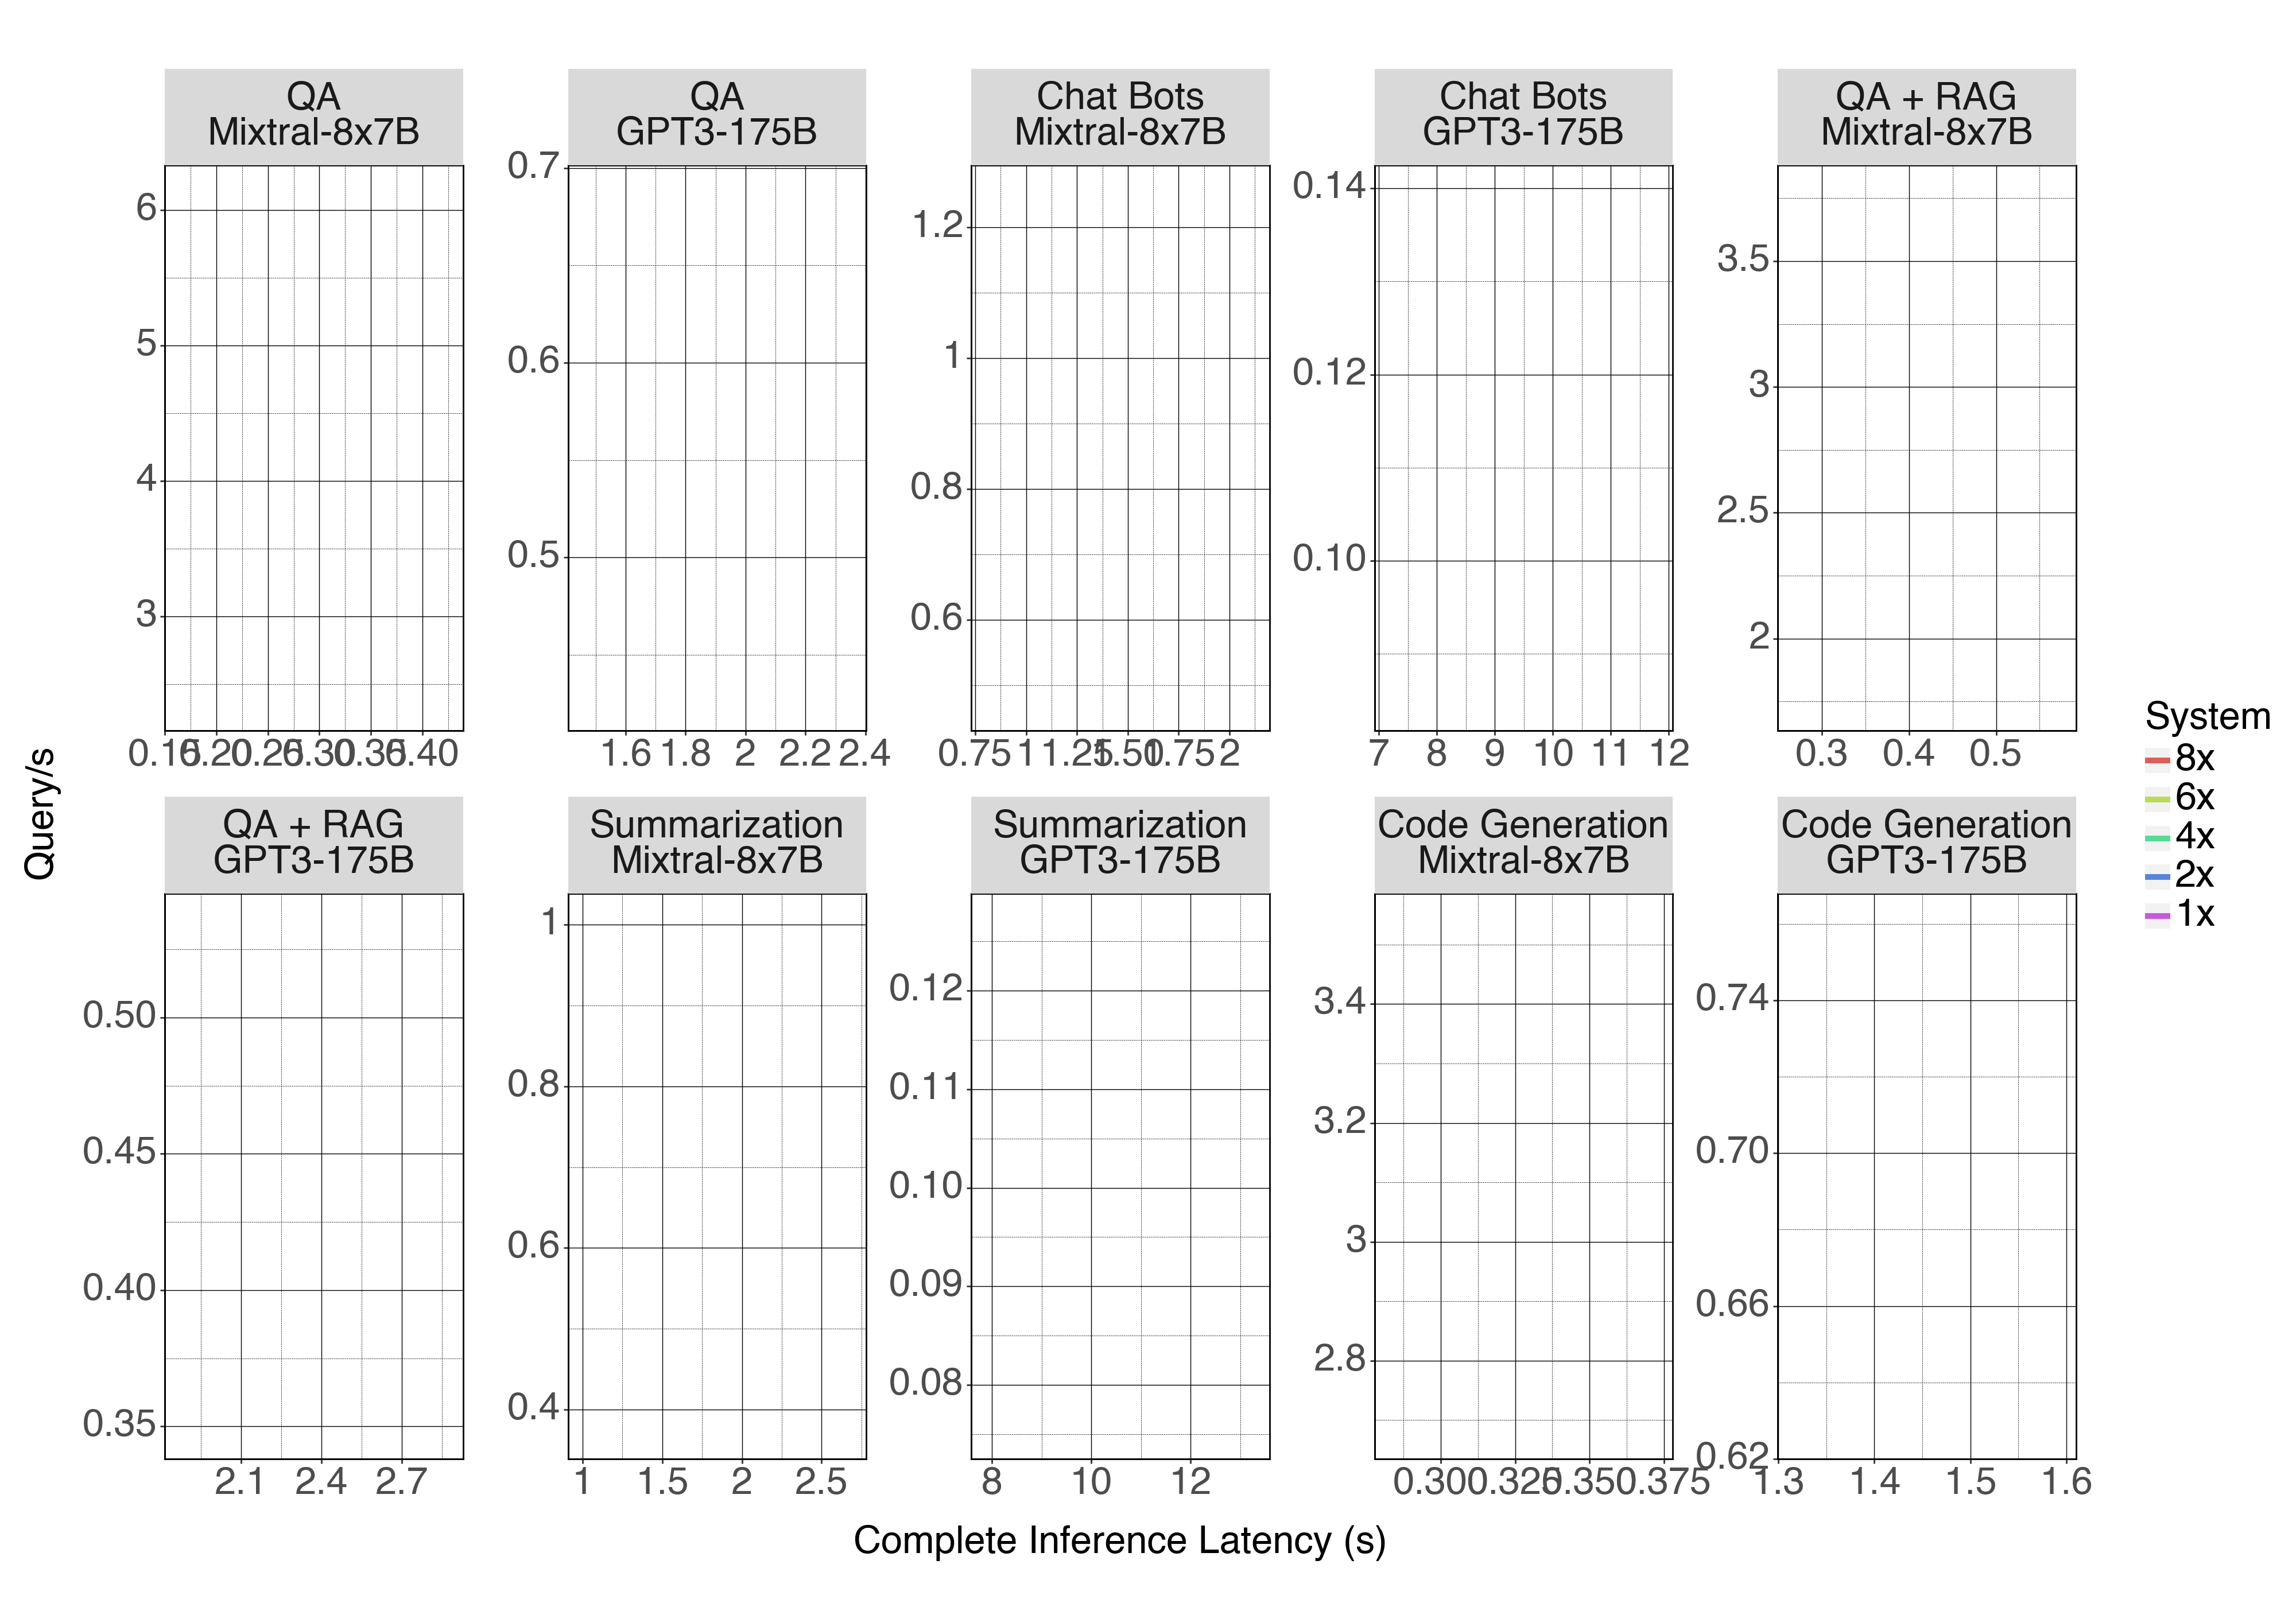

In [16]:


p1 = (
    p9.ggplot(plot_df, p9.aes(x='Latency (s)', y='QPS (Query/s)'))
    + p9.geom_line(p9.aes(color = 'System'), size=2) # line plot
    # + p9.geom_point(p9.aes(color='System'), size=3) # line plot
    + p9.labs(x='Complete Inference Latency (s)', y='Query/s')
    + plot_theme
    + p9.theme(figure_size=(20, 14))
    # + p9.scale_x_log10()
    # + p9.scale_y_log10()
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Usecase + Model", scales = 'free' , ncol=5 )
    # + p9.geom_text(aes(label=text_to_add), x=10, y=10, size=10, color='red', va='top', ha='left')

    # + p9.scale_x_continuous(
    #     limits=lambda data: x_lim_dict.get(data['Usecase'].unique()[0], 20)
    # )
)

print(p1)
# p9.ggsave(p1, f'/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/ARxiv/hypothetical_tflops_systems.pdf')

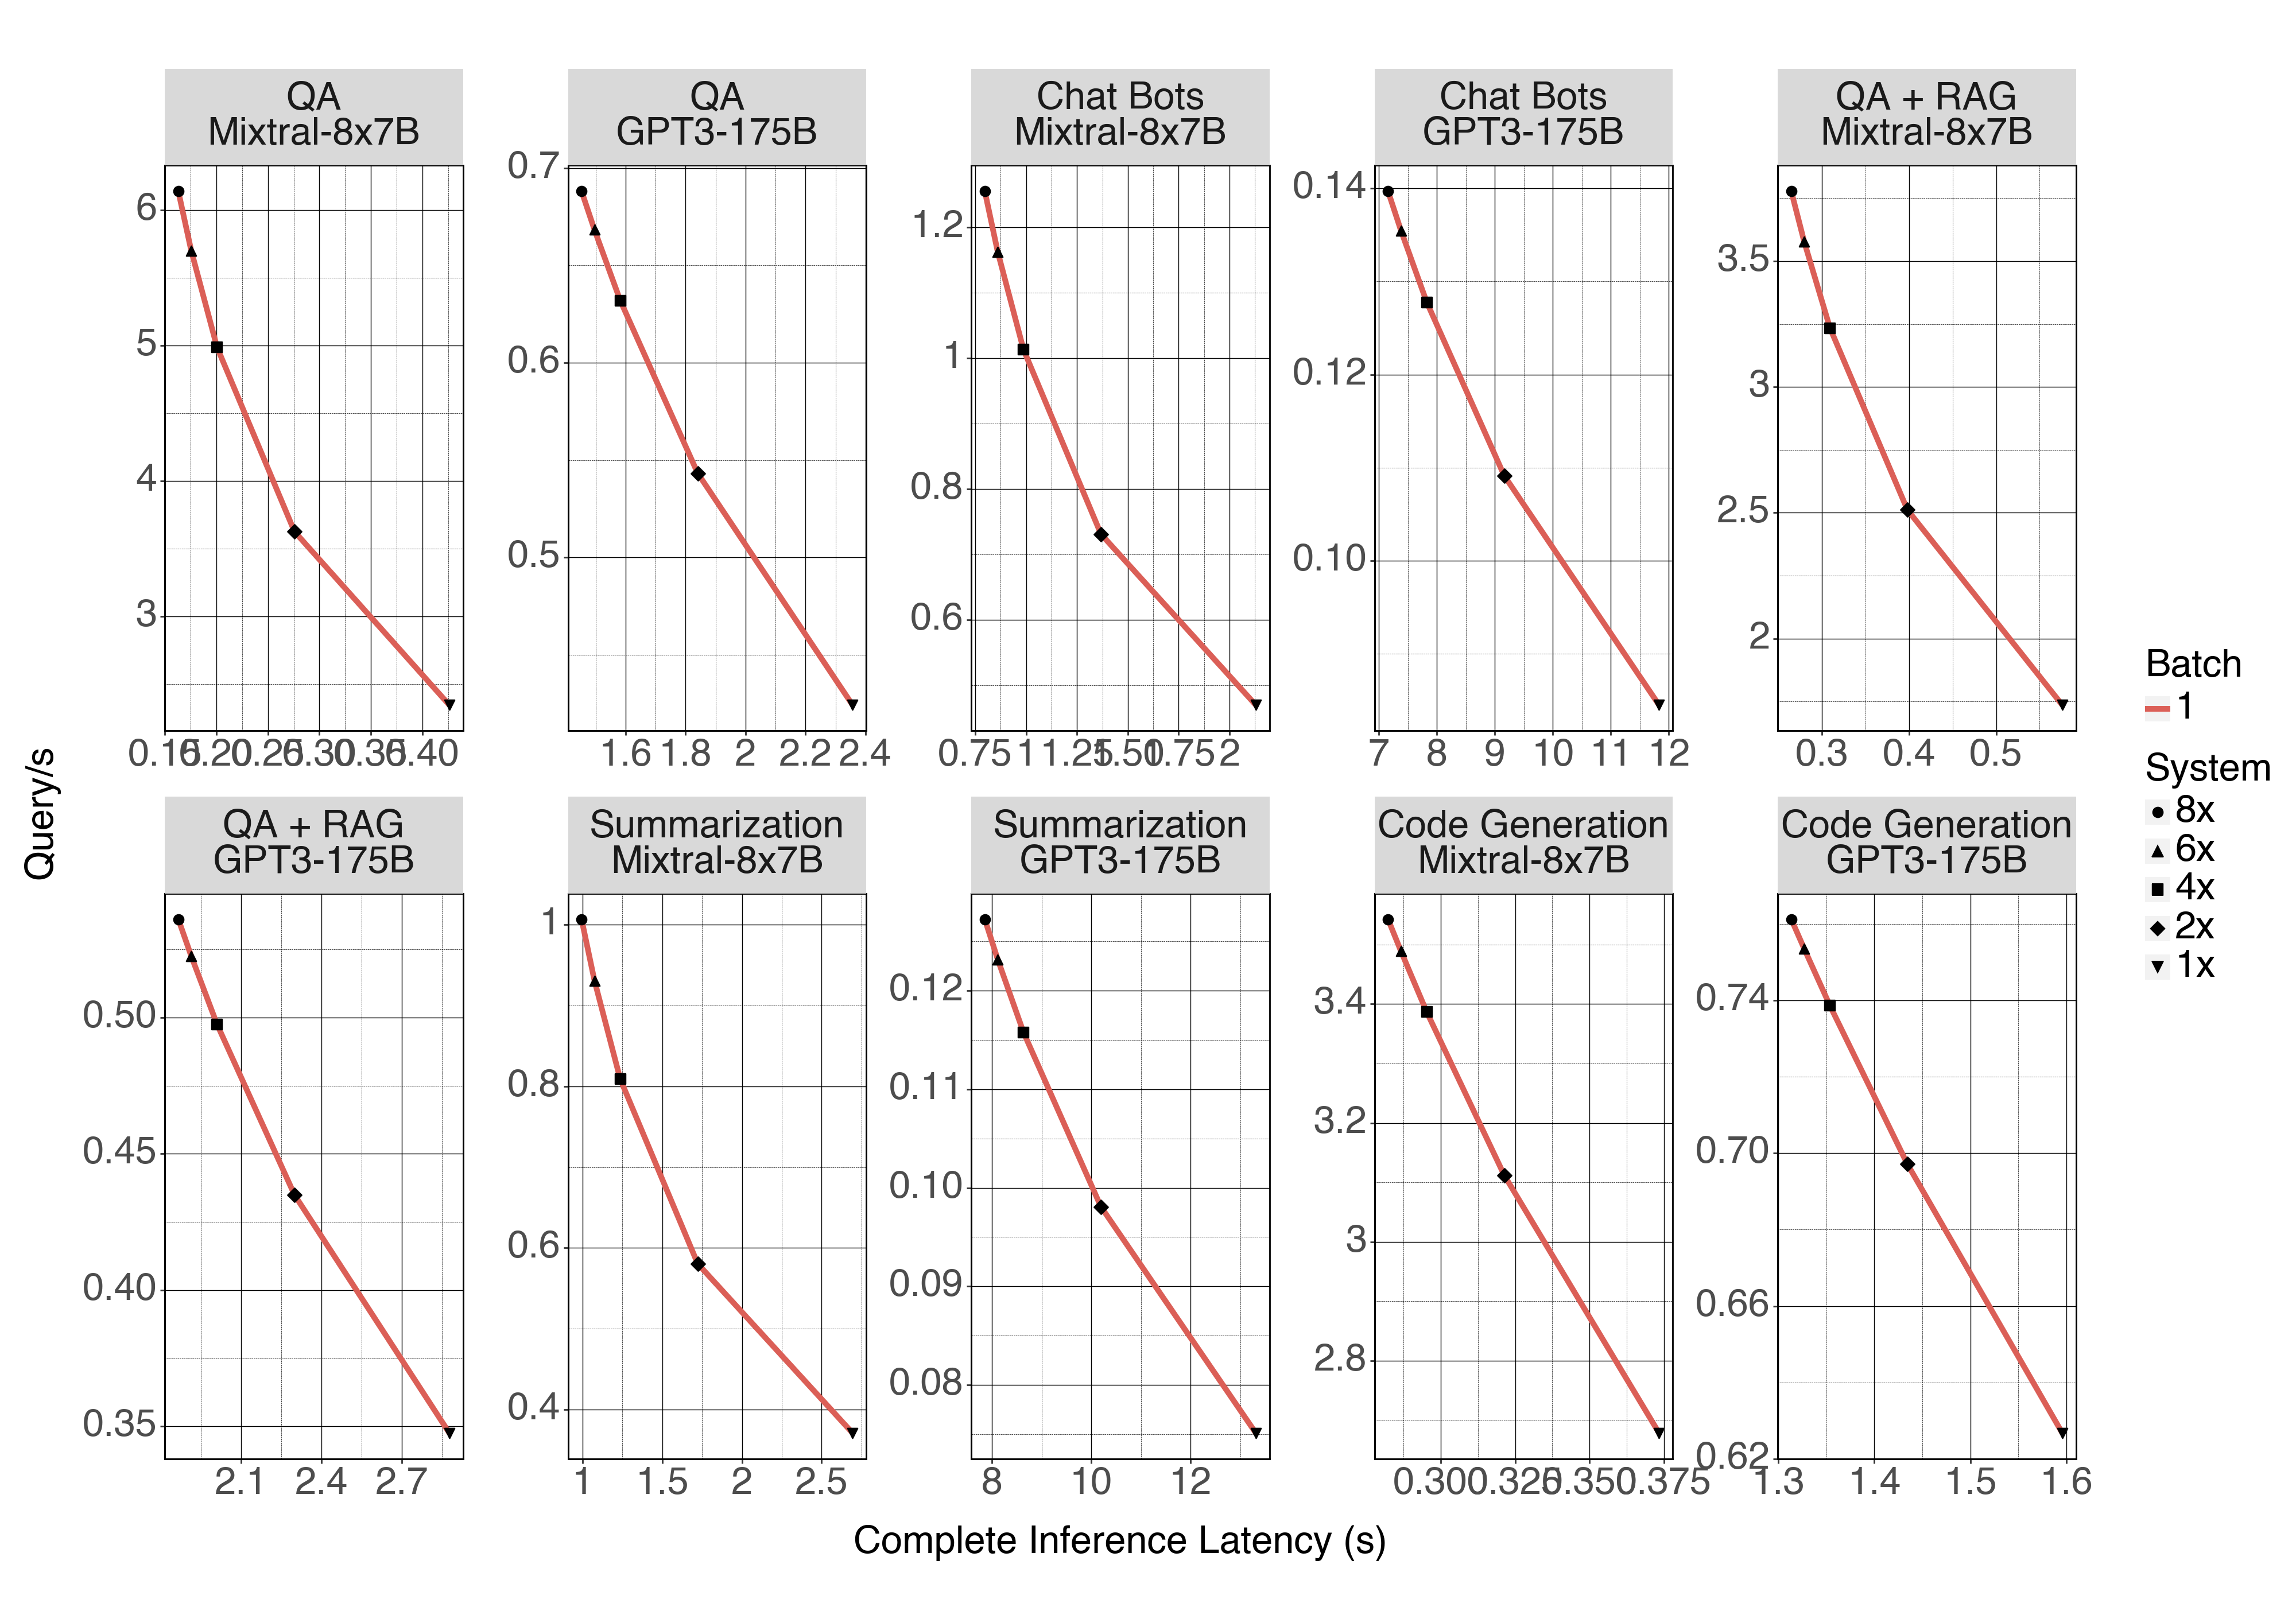

In [17]:
plot_df['Batch'] = pd.Categorical(plot_df['Batch'], categories=batch_size_list)
plot_df['Batch'] = plot_df['Batch'].astype(str)
p1 = (
    p9.ggplot(plot_df, p9.aes(x='Latency (s)', y='QPS (Query/s)'))
    + p9.geom_line(p9.aes(color = 'Batch'), size=2) # line plot
    + p9.geom_point(p9.aes(shape='System'), size=3) # line plot
    + p9.labs(x='Complete Inference Latency (s)', y='Query/s')
    + plot_theme
    + p9.theme(figure_size=(20, 14))
    # + p9.scale_x_log10()
    # + p9.scale_y_log10()
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Usecase + Model", scales = 'free' , ncol=5 )
)

print(p1)

In [18]:
plot_df.columns

Index(['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP',
       'PP', 'Cores Total Memory (MB)', 'MACs (MFLOP)', 'Total Data (MB)',
       'Model Weights (MB)', 'Unused Weights (MB)', 'KV Cache (MB)',
       'AR data (MB)', 'Pipe data  (MB)', 'Latency (ms)', 'QPS (Query/s)',
       'Prefill Attn Time (ms)', 'Prefill GEMM Time (ms)',
       'Prefill Communication Time (ms)', 'Decode Attn Time (ms)',
       'Decode GEMM Time (ms)', 'Decode Communication Time (ms)',
       'Latency (s)', 'QPS (Query/s))', 'Real Systems', 'Num Cores'],
      dtype='object')

In [19]:
breadkdown_df = plot_df[(plot_df['Usecase'] == 'Summarization') & (plot_df['Batch'] == '1') & (plot_df['Model'] != 'MoE-1.8T')]

In [20]:
breadkdown_df

,System,Usecase,Model,Batch,Req Memory Size(MB),TP,PP,Cores Total Memory (MB),MACs (MFLOP),Total Data (MB),...,Prefill Attn Time (ms),Prefill GEMM Time (ms),Prefill Communication Time (ms),Decode Attn Time (ms),Decode GEMM Time (ms),Decode Communication Time (ms),Latency (s),QPS (Query/s)),Real Systems,Num Cores
30,8x,Summarization,Mixtral-8x7B,1,48288.0,2,1,81920.0,67243.081728,24215.875000,...,36.864,118.279373,12.783031,0.064457,0.183849,0.579255,0.993467,1.006576,True,2
31,6x,Summarization,Mixtral-8x7B,1,48288.0,2,1,81920.0,67243.081728,24215.875000,...,36.864,118.279373,12.783031,0.084812,0.245132,0.579255,1.074467,0.930694,True,2
32,4x,Summarization,Mixtral-8x7B,1,48288.0,2,1,81920.0,67243.081728,24215.875000,...,36.864,118.279373,12.783031,0.125522,0.367699,0.579255,1.236467,0.808756,True,2
33,2x,Summarization,Mixtral-8x7B,1,48288.0,2,1,81920.0,67243.081728,24215.875000,...,36.864,118.279373,12.783031,0.247654,0.735397,0.579255,1.722467,0.580563,True,2
34,1x,Summarization,Mixtral-8x7B,1,48288.0,2,1,81920.0,67243.081728,24215.875000,...,36.864,118.279373,12.783031,0.491916,1.470795,0.579255,2.694467,0.371131,True,2
35,8x,Summarization,GPT3-175B,1,208638.0,8,1,327680.0,185152.831488,26147.654297,...,82.944,407.686349,198.596742,0.165386,0.633568,6.387270,7.858029,0.127258,True,8
36,6x,Summarization,GPT3-175B,1,208638.0,8,1,327680.0,185152.831488,26147.654297,...,82.944,407.686349,198.596742,0.219760,0.844757,6.387270,8.117864,0.123185,True,8
37,4x,Summarization,GPT3-175B,1,208638.0,8,1,327680.0,185152.831488,26147.654297,...,82.944,407.686349,198.596742,0.328507,1.267136,6.387270,8.637535,0.115774,True,8
38,2x,Summarization,GPT3-175B,1,208638.0,8,1,327680.0,185152.831488,26147.654297,...,82.944,407.686349,198.596742,0.654750,2.534271,6.387270,10.196546,0.098072,True,8
39,1x,Summarization,GPT3-175B,1,208638.0,8,1,327680.0,185152.831488,26147.654297,...,82.944,407.686349,198.596742,1.307235,5.068542,6.387270,13.314569,0.075106,True,8


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_54214/4215303059.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_54214/4215303059.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_54214/4215303059.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


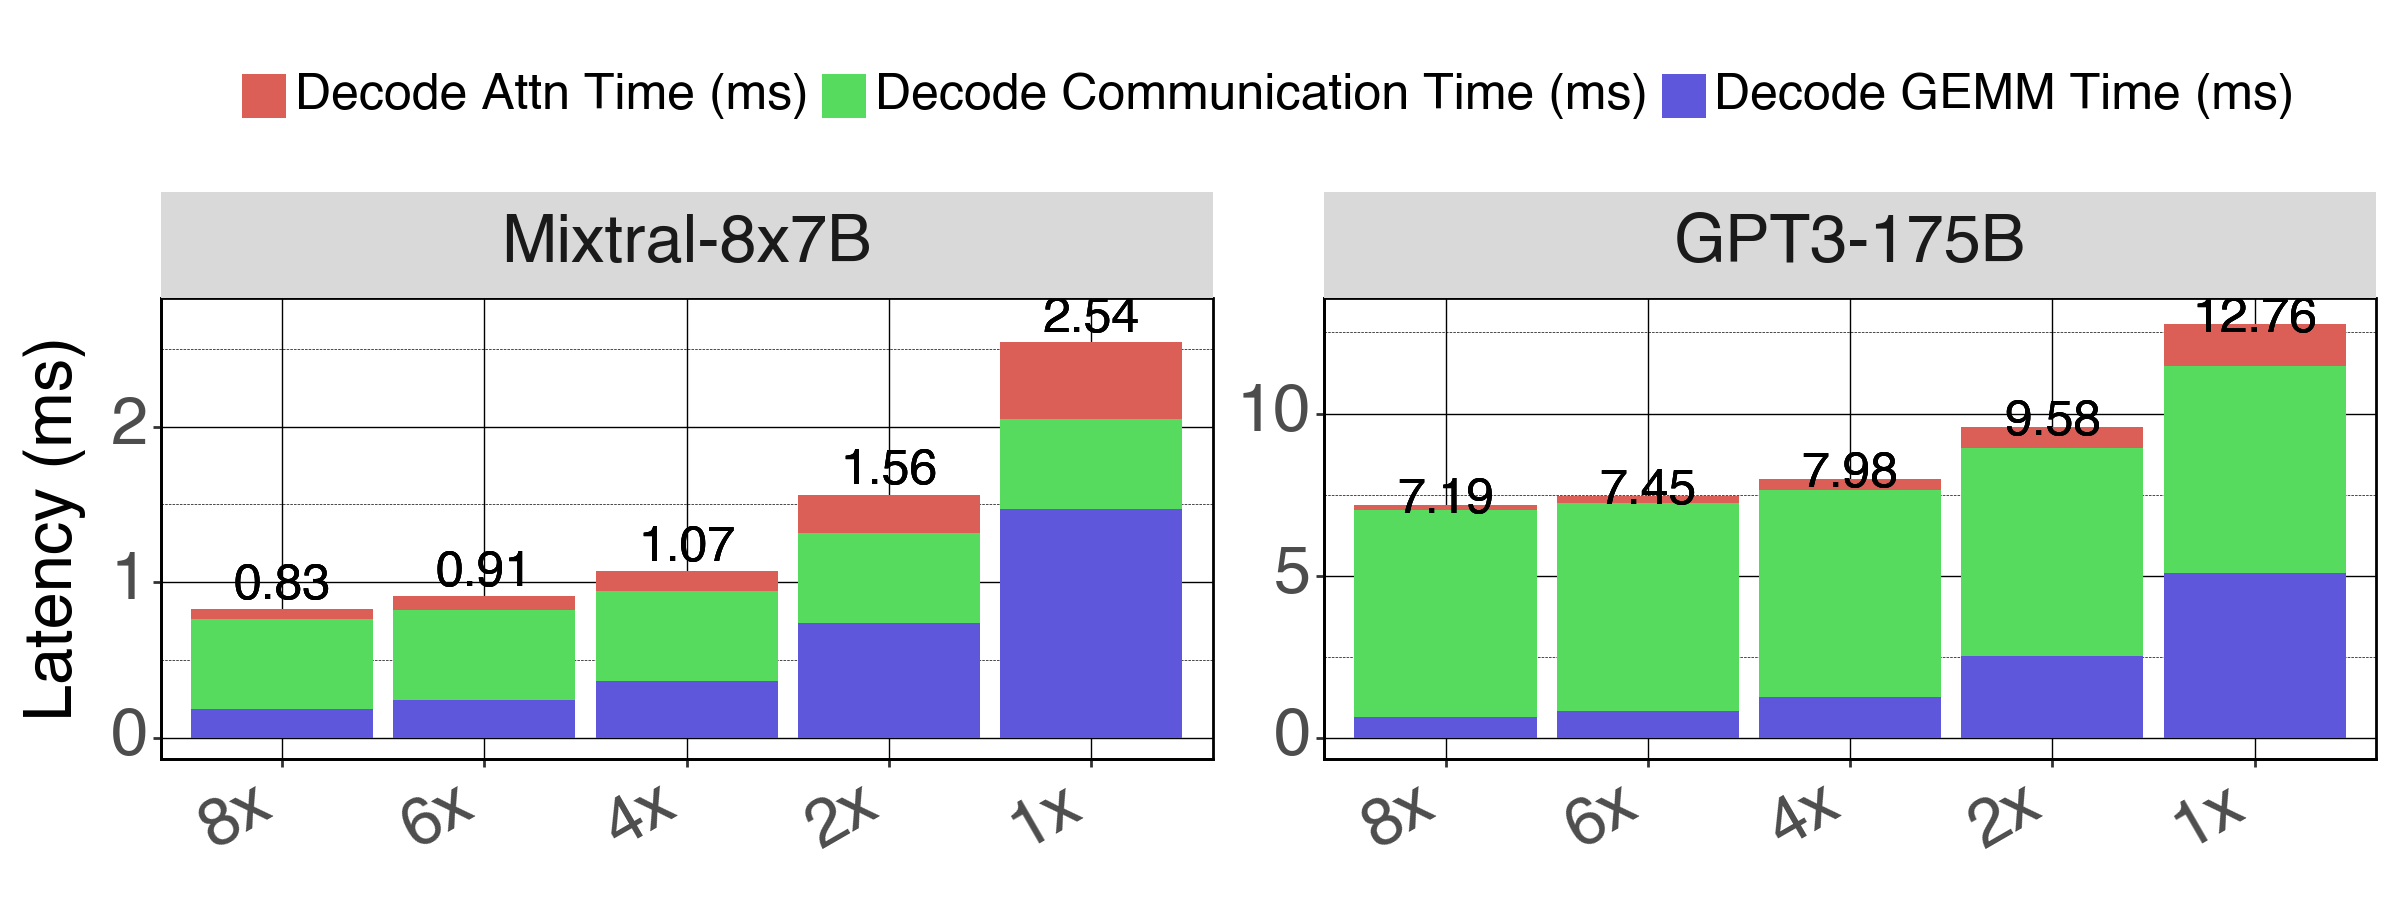

/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 4.55 in image.
/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/MemBW_scaling_decode.pdf


In [21]:
df_long = pd.melt(breadkdown_df, id_vars=['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP',
       'PP', 'Cores Total Memory (MB)', 'MACs (MFLOP)', 'Total Data (MB)',
       'Model Weights (MB)', 'Unused Weights (MB)', 'KV Cache (MB)',
       'AR data (MB)', 'Pipe data  (MB)', 'Latency (ms)', 'QPS (Query/s)',
       'Prefill Attn Time (ms)', 'Prefill GEMM Time (ms)',
       'Prefill Communication Time (ms)', 
       'Latency (s)', 'QPS (Query/s))', 'Real Systems', 'Num Cores'], var_name="Time")
df_long['value'] = df_long['value'].astype(float)
df_long['total'] = df_long.groupby(['System', 'Model'])['value'].transform('sum')

df_long = df_long.replace(Model_list, Model_names_in_plot)
df_ratios = (df_long.groupby(['System', 'Model'])['total']
                    .max()
                    .reset_index()
                    .rename(columns={'total': 'max_value'}))
df_ratios['ratio'] =  df_ratios.groupby('Model')['max_value'].transform('max') /df_ratios['max_value'] 
# for _usecase_ in df_long['Usecase'].unique():
plot = (
    ggplot(df_long, aes(x='System',y='value',fill ='Time'))
    + geom_bar(stat='identity',position='stack') 
    + p9.labs(y='Latency (ms)', x='')
    + plot_theme
    + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1), axis_title_x=p9.element_blank())
    + p9.theme(figure_size=(12, 5.5),legend_text=p9.element_text(size=18),legend_title=p9.element_blank())
    + theme(figure_size=(12,4.55), legend_position='top')
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Model ", scales = 'free' , ncol=5)
    + geom_text(aes(x='System', y='total+0.15', label='total'), format_string='{:.2f}', stat='summary', size=18, color='black') 

    # + p9.faceh_wrap("Usecase", scales = 'free' , )
)
print(plot)
p9.ggsave(plot, f'/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/MemBW_scaling_decode.pdf', dpi=500)

In [22]:
df_ratios

,System,Model,max_value,ratio
0,8x,Mixtral-8x7B,0.827561,3.071636
1,8x,GPT3-175B,7.186224,1.776044
2,6x,Mixtral-8x7B,0.909199,2.795829
3,6x,GPT3-175B,7.451787,1.712750
4,4x,Mixtral-8x7B,1.072476,2.370184
5,4x,GPT3-175B,7.982913,1.598796
6,2x,Mixtral-8x7B,1.562306,1.627060
7,2x,GPT3-175B,9.576291,1.332776
8,1x,Mixtral-8x7B,2.541966,1.000000
9,1x,GPT3-175B,12.763047,1.000000


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_54214/2322682679.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


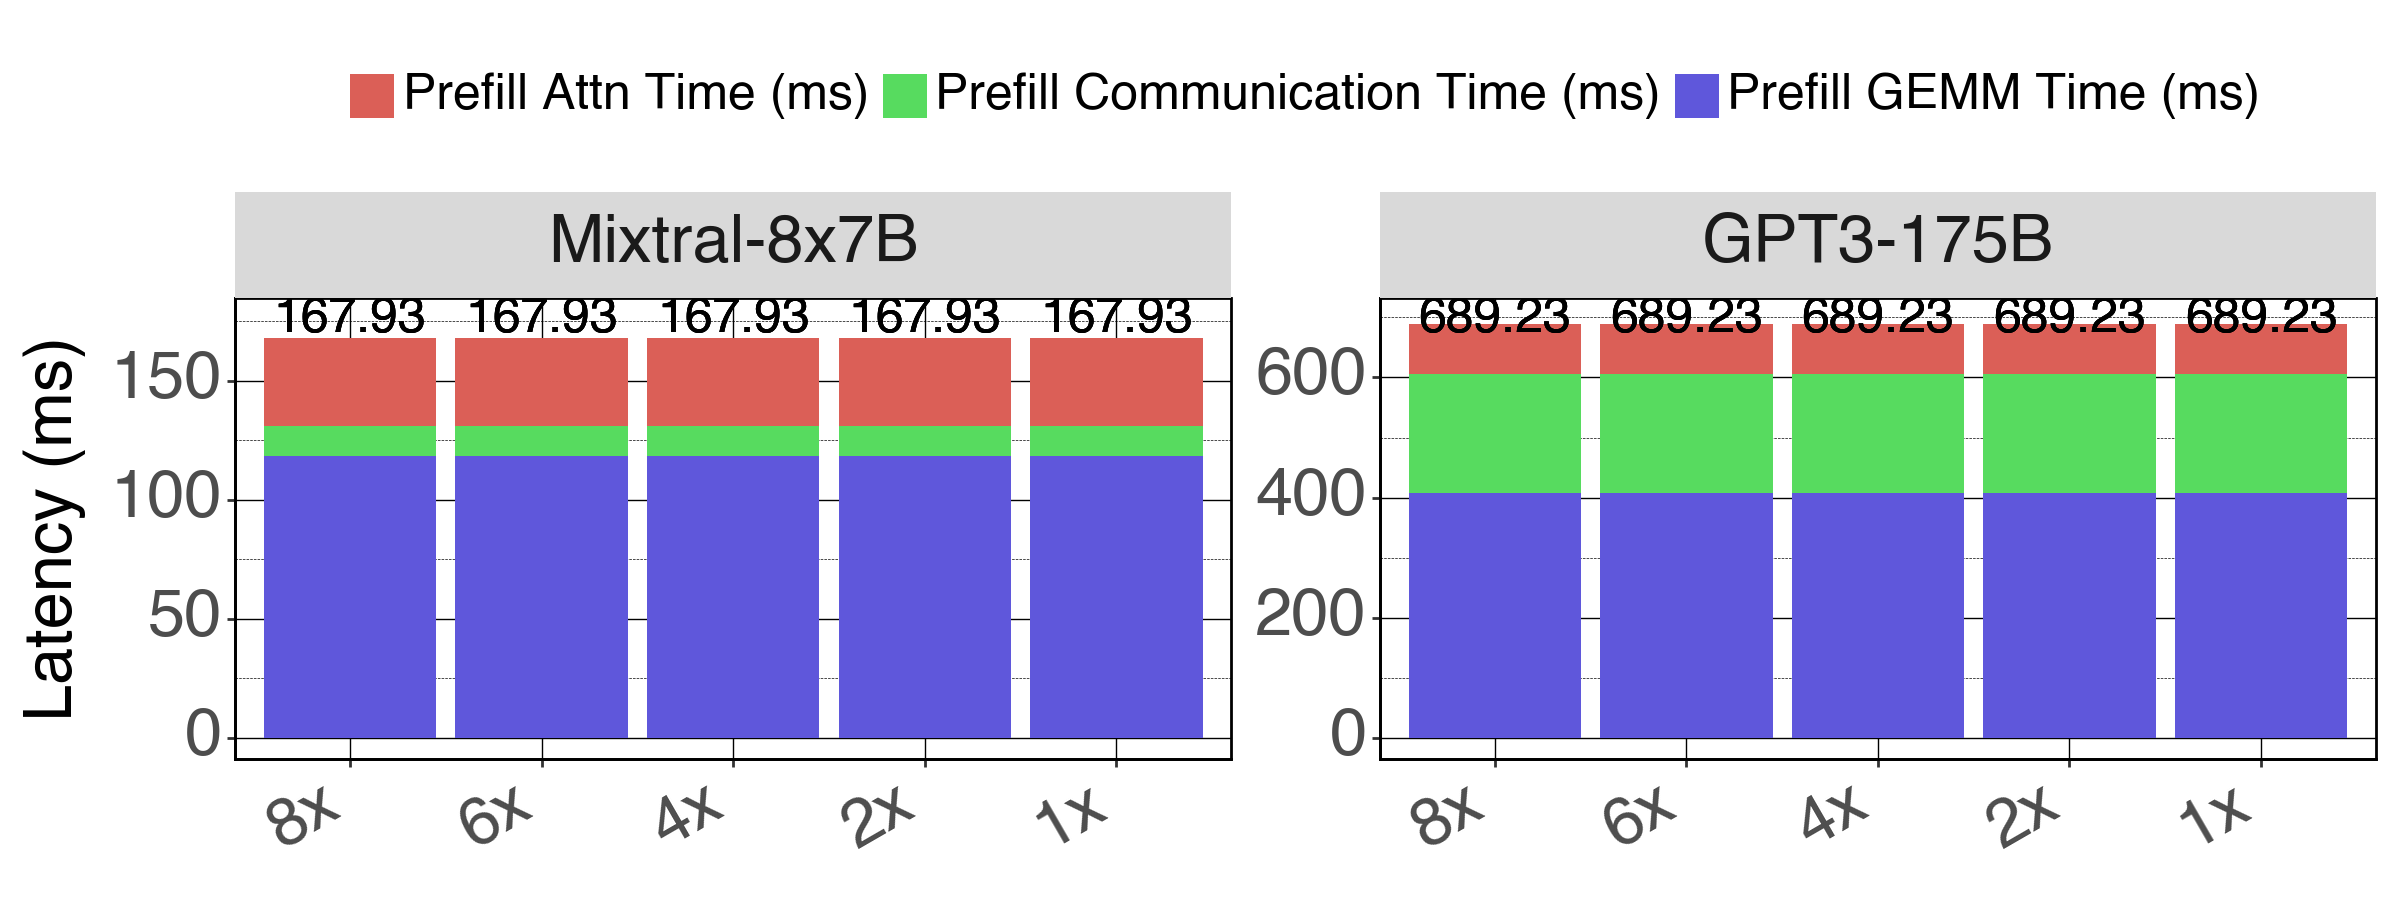

/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 4.55 in image.
/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/MemBW_scaling_prefill.pdf


In [23]:
df_long = pd.melt(breadkdown_df, id_vars=['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP',
       'PP', 'Cores Total Memory (MB)', 'MACs (MFLOP)', 'Total Data (MB)',
       'Model Weights (MB)', 'Unused Weights (MB)', 'KV Cache (MB)',
       'AR data (MB)', 'Pipe data  (MB)', 'Latency (ms)', 'QPS (Query/s)',
       'Decode Attn Time (ms)', 'Decode GEMM Time (ms)',
       'Decode Communication Time (ms)', 
       'Latency (s)', 'QPS (Query/s))', 'Real Systems', 'Num Cores'], var_name="Time")
df_long['value'] = df_long['value'].astype(float)
df_long['total'] = df_long.groupby(['System', 'Model'])['value'].transform('sum')

df_long = df_long.replace(Model_list, Model_names_in_plot)

# for _usecase_ in df_long['Usecase'].unique():
plot = (
    ggplot(df_long, aes(x='System',y='value',fill ='Time'))
    + geom_bar(stat='identity',position='stack') 
    + p9.labs(y='Latency (ms)', x='')
    + plot_theme
    + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1), axis_title_x=p9.element_blank())
    + p9.theme(figure_size=(12, 5.5),legend_text=p9.element_text(size=18),legend_title=p9.element_blank())
    + theme(figure_size=(12,4.55), legend_position='top')
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Model ", scales = 'free' , ncol=5)
    + geom_text(aes(x='System', y='total+8', label='total'), format_string='{:.2f}', stat='summary', size=18, color='black') 

    # + p9.faceh_wrap("Usecase", scales = 'free' , )
)
print(plot)
p9.ggsave(plot, f'/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/MemBW_scaling_prefill.pdf', dpi=500)

In [24]:
get_best_parallization_strategy(stage='decode', model='gpt-3', total_nodes=8, batch_size = 1, beam_size = 4,
                                input_tokens = 15000, output_tokens = 1000,
                                system_name =  {'Flops': 3200, 'Memory_size': 80, 'Memory_BW': 16000, 'ICN': 300 , 'real_values':True}, bits='int8', debug=False)

,micro batch,TP,PP,Latency(ms),Tokens/s,GEMM time,SA time,Comm. time
1,1,4,1,6.428923,155.547056,2.533173,0.657015,3.307945


In [25]:
get_best_parallization_strategy(stage='decode', model='gpt-3', total_nodes=8, batch_size = 1, beam_size = 4,
                                input_tokens = 15000, output_tokens = 1000,
                                system_name =  {'Flops': 3200, 'Memory_size': 80, 'Memory_BW': 24000, 'ICN': 300 , 'real_values':True}, bits='int8', debug=False)

,micro batch,TP,PP,Latency(ms),Tokens/s,GEMM time,SA time,Comm. time
1,1,4,1,5.389948,185.530549,1.688782,0.43952,3.307945
